# Retail Customer Segmentation - Unsupervised ML
## Objective: 
- Discover and analyze natural customer groupings to inform targeted marketing strategies, product recommendations, and business decisions.


### 1. Environment Setup, Data Loading and Exploration
First, let's import all necessary libraries, load our dataset and visualize the data.

Merged dataset shape: (1000, 38)

First 5 rows:


,customer_id,age,gender,annual_income,education,marital_status,city,state,country,postal_code,...,cart_abandonment_rate,email_engagement_rate,support_tickets,satisfaction_score,total_transactions,total_spend,avg_spend,total_items,avg_items_per_txn,favorite_category
0,7e58732d,58,Male,76754,High School,Divorced,Curtisfurt,CT,US,47553,...,54,0,1,7.0,11,326.88,29.716364,23,2.090909,Beauty
1,5371a919,19,Non-binary,36083,Associate Degree,Widowed,New Jessica,GA,US,61090,...,59,16,1,5.6,9,375.21,41.690000,17,1.888889,Beauty
2,4a71a294,42,Male,45852,Bachelor Degree,Divorced,Hurstfurt,MN,US,29247,...,40,65,0,6.9,9,335.86,37.317778,25,2.777778,Clothing
3,23165a5e,30,Non-binary,34021,High School,Single,Teresaburgh,NY,US,14448,...,51,23,1,6.4,10,312.88,31.288000,24,2.400000,Books
4,dcb1e818,62,Non-binary,90889,High School,Married,East Donna,OH,US,22144,...,62,42,0,6.9,22,989.46,44.975455,47,2.136364,Electronics



Numerical summary:


,age,annual_income,total_spend,total_transactions,avg_spend,total_items,website_visits_per_month
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000
mean,46.849000,67893.698000,379.483900,10.000000,37.877719,21.3070,4.797000
std,16.583221,35964.928189,281.054439,3.116683,24.066782,7.5916,2.655342
min,18.000000,13230.000000,24.900000,1.000000,10.121429,1.0000,0.000000
25%,33.000000,42394.750000,170.212500,8.000000,16.233542,16.0000,3.000000
50%,47.000000,60912.000000,296.875000,10.000000,32.437929,20.0000,5.000000
75%,61.000000,84901.000000,503.257500,12.000000,52.713897,26.0000,6.000000
max,75.000000,289534.000000,2028.050000,22.000000,175.370000,48.0000,13.000000



Categorical summary:

gender distribution:


gender
Non-binary    352
Male          332
Female        316
Name: count, dtype: int64


education distribution:


education
Master Degree       233
Associate Degree    198
High School         196
PhD                 194
Bachelor Degree     179
Name: count, dtype: int64


marital_status distribution:


marital_status
Single      268
Widowed     249
Married     248
Divorced    235
Name: count, dtype: int64


favorite_payment_method distribution:


favorite_payment_method
Bank Transfer    189
Apple Pay        184
PayPal           167
Credit Card      160
Google Pay       151
Name: count, dtype: int64


favorite_category distribution:


favorite_category
Books          191
Beauty         190
Clothing       148
Electronics    130
Food           122
Name: count, dtype: int64


Missing values:


customer_id                 0
age                         0
gender                      0
annual_income               0
education                   0
marital_status              0
city                        0
state                       0
country                     0
postal_code                 0
signup_date                 0
purchase_frequency          0
avg_purchase_value          0
total_spent                 0
days_since_last_purchase    0
favorite_payment_method     0
electronics_score           0
clothing_score              0
home_decor_score            0
beauty_score                0
sports_score                0
books_score                 0
food_score                  0
website_visits_per_month    0
avg_session_duration        0
mobile_app_usage            0
desktop_usage               0
items_viewed_per_visit      0
cart_abandonment_rate       0
email_engagement_rate       0
support_tickets             0
satisfaction_score          0
total_transactions          0
total_spen

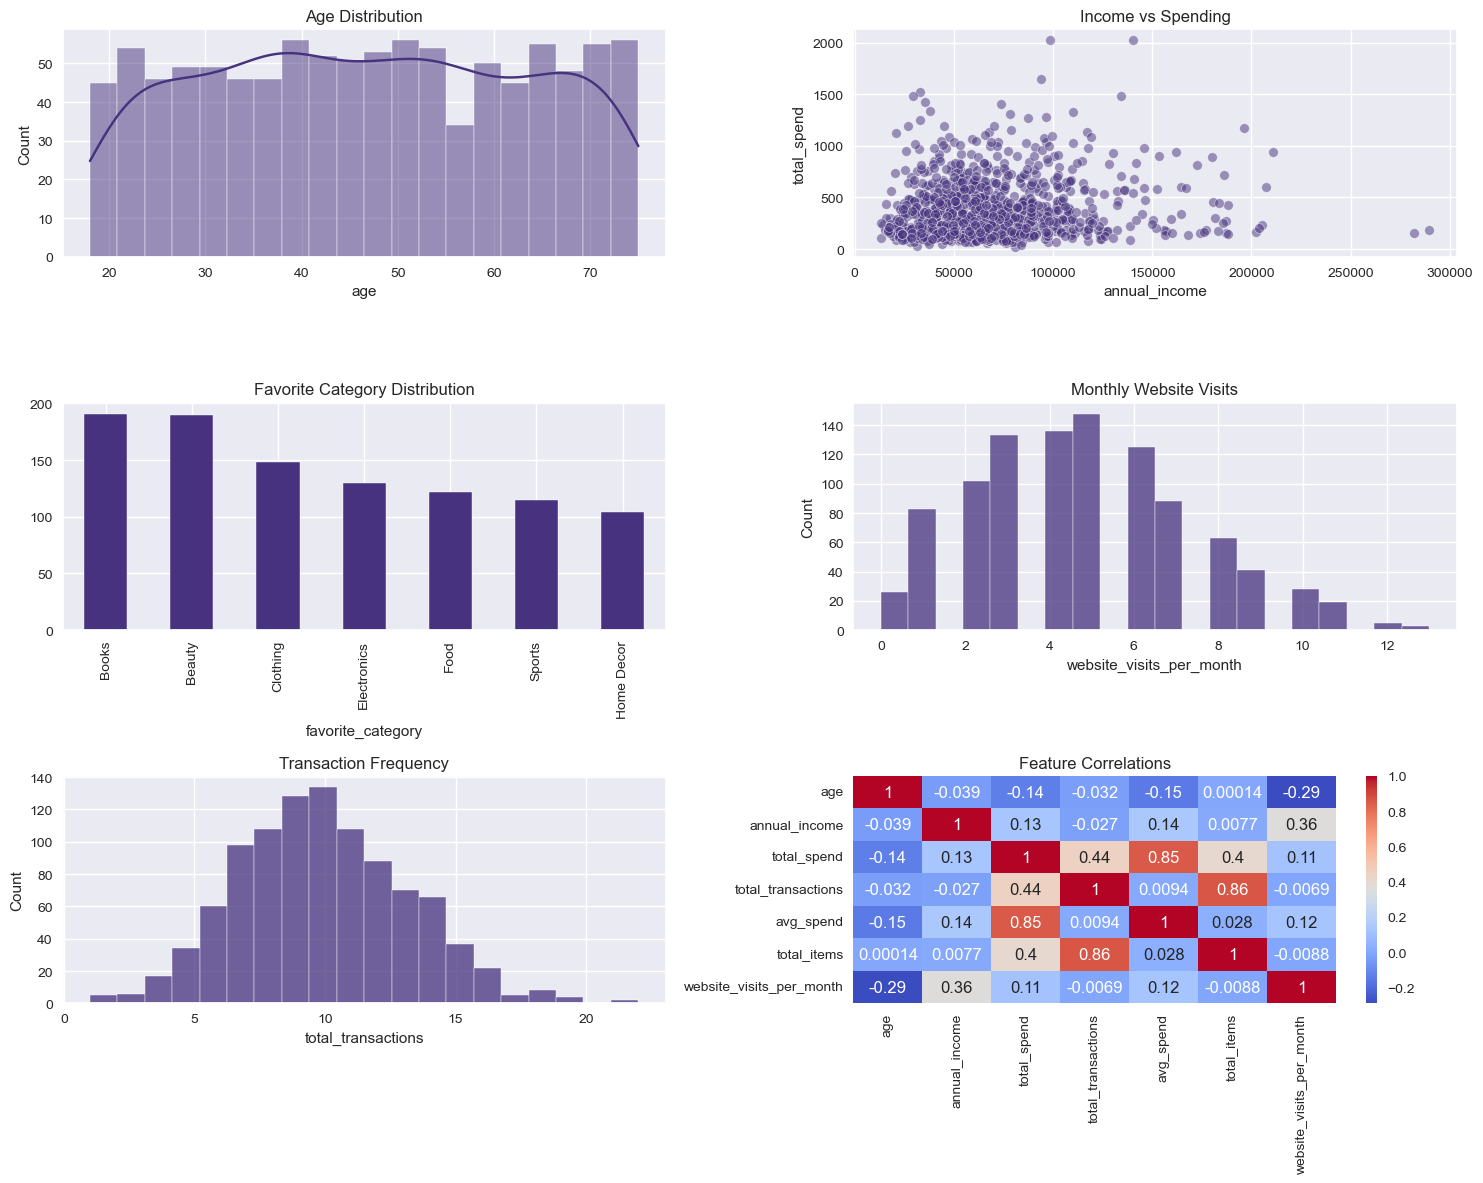

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# scikit-learn libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import datetime as dt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import plotly.express as px  
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


# Plotting style and theme
sns.set_palette('viridis')
sns.set_style('darkgrid')

# Load datasets (without preprocessing)
customer_df = pd.read_csv('data/retail_customer_data.csv')
transactions_df = pd.read_csv('data/customer_transactions.csv')

# Create transaction features
transaction_features = transactions_df.groupby('customer_id').agg(
    total_transactions=('transaction_id', 'count'),
    total_spend=('transaction_amount', 'sum'),
    avg_spend=('transaction_amount', 'mean'),
    total_items=('item_count', 'sum'),
    avg_items_per_txn=('item_count', 'mean'),
    favorite_category=('item_category', lambda x: x.mode()[0] if not x.empty else np.nan)
).reset_index()

# Merge datasets
merged_df = pd.merge(customer_df, transaction_features, 
                    on='customer_id', how='left')

# Basic dataset information
print(f"Merged dataset shape: {merged_df.shape}")
print("\nFirst 5 rows:")
display(merged_df.head())

# Numerical summary
numerical_cols = ['age', 'annual_income', 'total_spend', 'total_transactions', 
                 'avg_spend', 'total_items', 'website_visits_per_month']
print("\nNumerical summary:")
display(merged_df[numerical_cols].describe())

# Categorical summary
categorical_cols = ['gender', 'education', 'marital_status', 'favorite_payment_method', 
                   'favorite_category']
print("\nCategorical summary:")
for col in categorical_cols:
    print(f"\n{col} distribution:")
    display(merged_df[col].value_counts(dropna=False).head())

# Missing values
print("\nMissing values:")
display(merged_df.isnull().sum())

# Visualizations
plt.figure(figsize=(15, 12))

# Age distribution
plt.subplot(3, 2, 1)
sns.histplot(merged_df['age'], bins=20, kde=True)
plt.title('Age Distribution')

# Annual income vs Total spend
plt.subplot(3, 2, 2)
sns.scatterplot(x='annual_income', y='total_spend', 
                data=merged_df, alpha=0.5)
plt.title('Income vs Spending')

# Favorite category
plt.subplot(3, 2, 3)
merged_df['favorite_category'].value_counts(dropna=False).plot(kind='bar')
plt.title('Favorite Category Distribution')

# Website engagement
plt.subplot(3, 2, 4)
sns.histplot(merged_df['website_visits_per_month'], bins=20)
plt.title('Monthly Website Visits')

# Transaction count distribution
plt.subplot(3, 2, 5)
sns.histplot(merged_df['total_transactions'].dropna(), bins=20)
plt.title('Transaction Frequency')

# Correlation heatmap
plt.subplot(3, 2, 6)
corr_matrix = merged_df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlations')

plt.tight_layout()
plt.show()



### 2. Data Preprocessing
Let's handle missing values, encode categorical variables, and scale numerical features

In [2]:

# Create RFM features from transactions
transaction_features = transactions_df.groupby('customer_id').agg(
    total_spend=('transaction_amount', 'sum'),
    total_transactions=('transaction_id', 'count'),
    avg_spend=('transaction_amount', 'mean'),
    transaction_recency=('transaction_date', lambda x: (pd.to_datetime('2025-04-01') - pd.to_datetime(x.max())).days)
).reset_index()
# Merge with customer data
merged_df = pd.merge(customer_df, transaction_features, on='customer_id', how='left')

# Create purchase flags using actual category scores
category_cols = ['electronics', 'clothing', 'home_decor', 'beauty', 'sports', 'books', 'food']

# Create flags based on category scores > median
for category in category_cols:
    merged_df[f'purchased_{category}'] = (merged_df[f'{category}_score'] > 
                                        merged_df[f'{category}_score'].median()).astype(int)

# Final feature set
features = merged_df[[
    'annual_income', 'age', 'total_spend', 'total_transactions',
    'transaction_recency', 'electronics_score', 'beauty_score',
    'sports_score', 'purchased_electronics', 'purchased_beauty'
]]

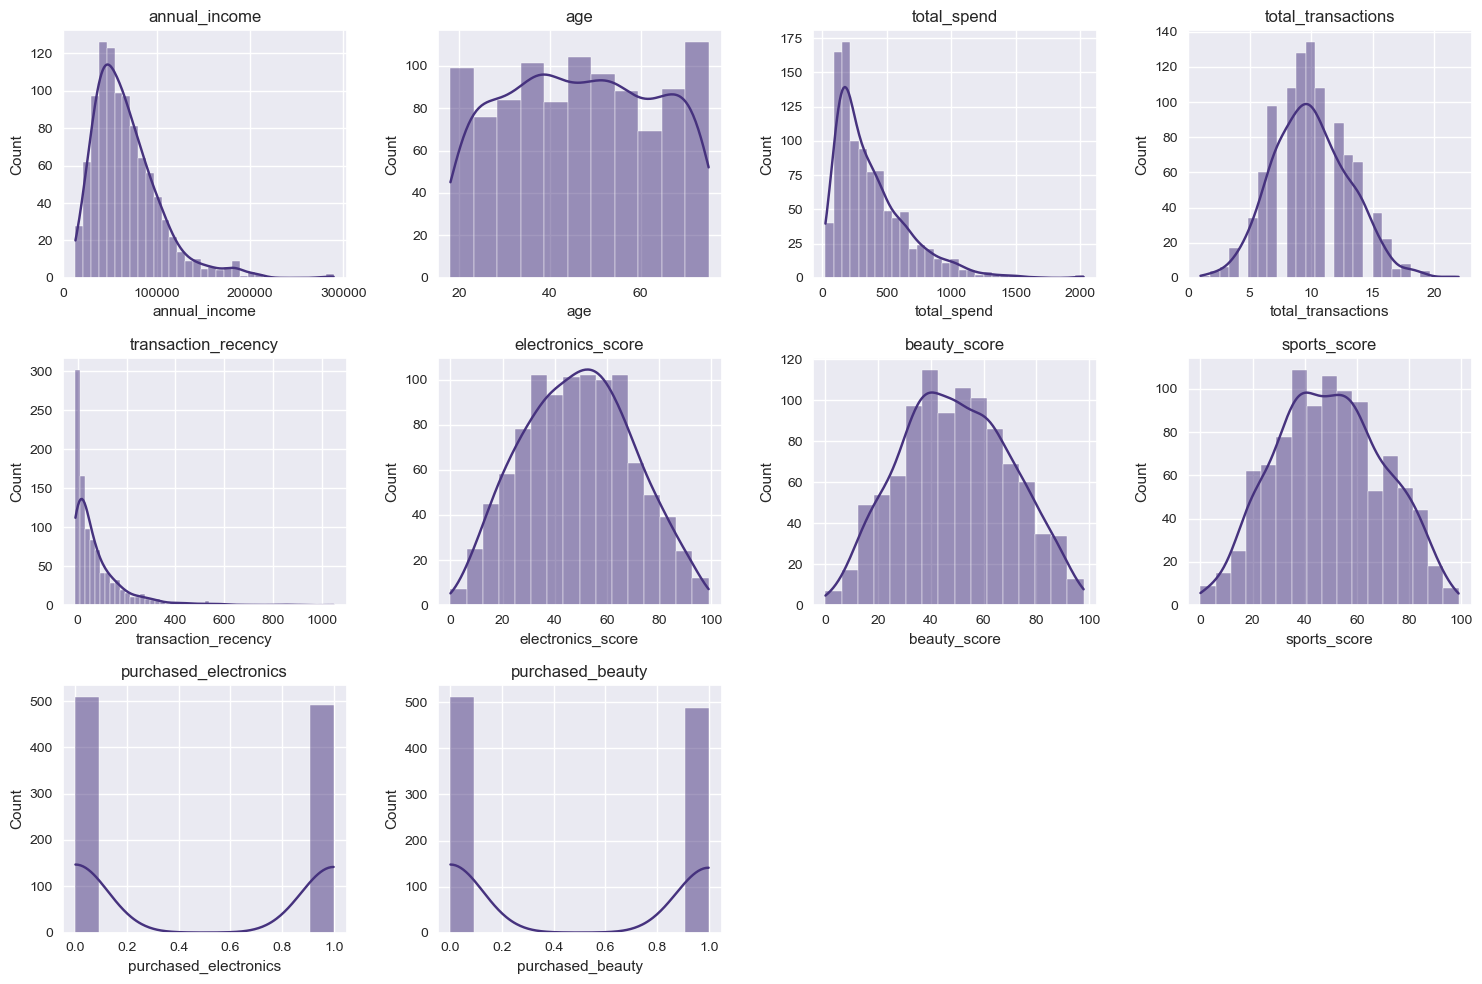

In [3]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(features.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(features[col], kde=True)
    plt.title(col)
plt.tight_layout()

In [4]:
# Handle missing values
features = features.copy()
features['total_spend'] = features['total_spend'].fillna(0)
features['total_transactions'] = features['total_transactions'].fillna(0)
features['transaction_recency'] = features['transaction_recency'].fillna(365)  # Changed column name

# Encode categorical features (if any)
features = pd.get_dummies(features, drop_first=True)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Text(0.5, 1.0, 'Feature Correlation Matrix')

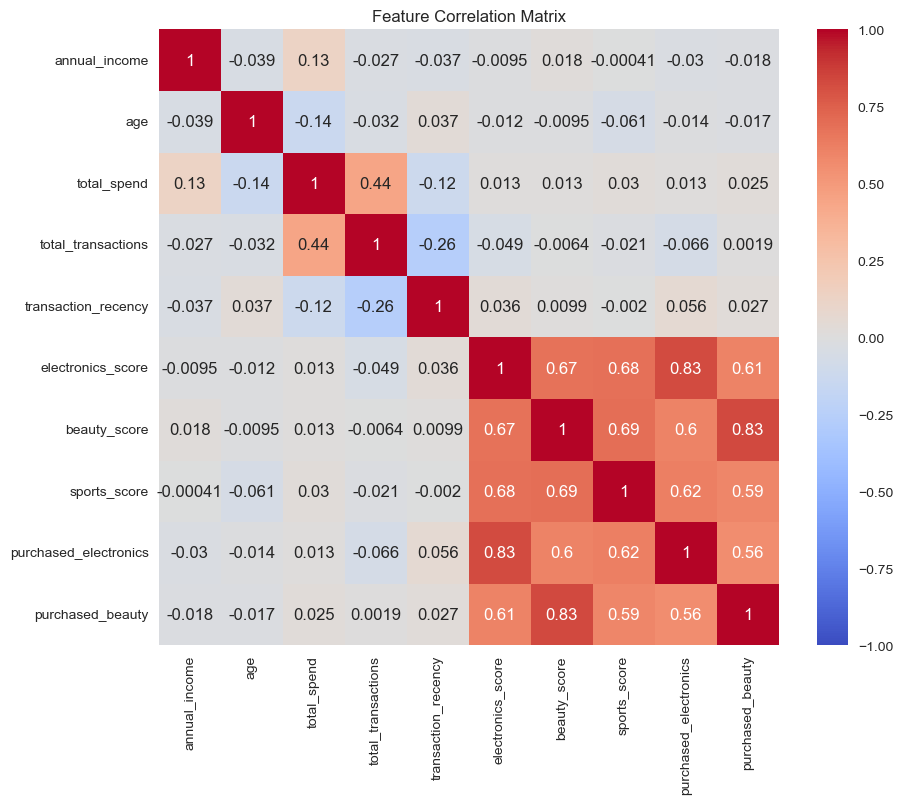

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(scaled_features, columns=features.columns).corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')

### 3. PCA

In [6]:
pca = PCA(n_components=3, random_state=42)
pca_features = pca.fit_transform(scaled_features)
print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.2f}")

# Create PCA dataframe
pca_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2', 'PC3'])

Explained variance: 0.63


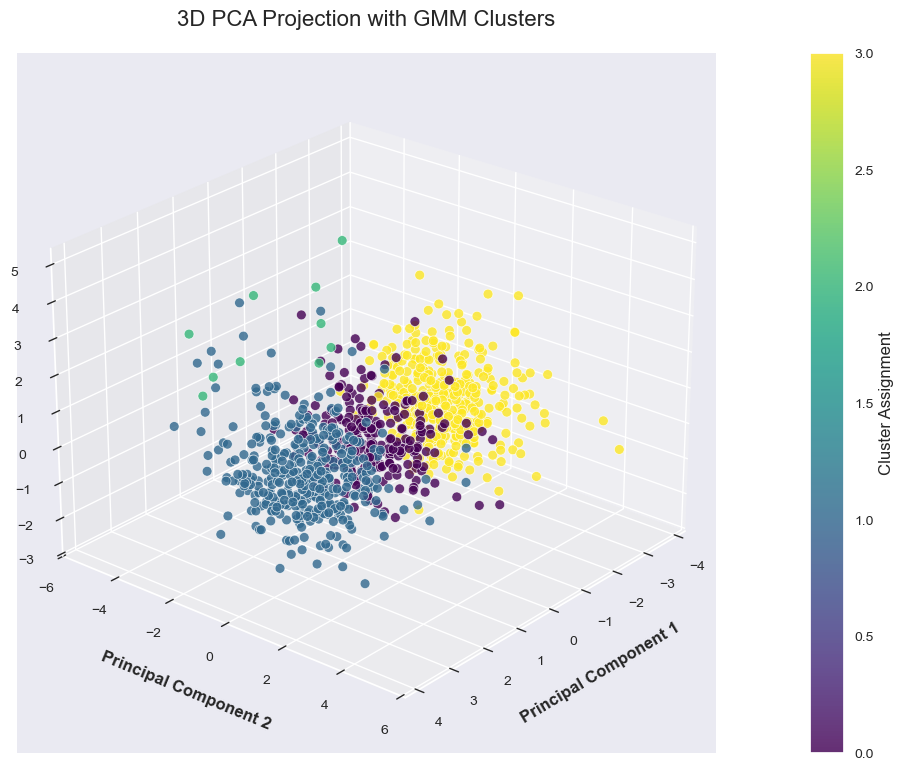

In [7]:
# First fit the GMM model
gmm = GaussianMixture(n_components=4, random_state=42)
clusters_gmm = gmm.fit_predict(scaled_features)
membership_probs = gmm.predict_proba(scaled_features)

# Create PCA DataFrame with components and add GMM results
pca_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2', 'PC3'])
pca_df['gmm_cluster'] = clusters_gmm
pca_df['membership_strength'] = membership_probs.max(axis=1)

# Now create the 3D visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                    c=pca_df['gmm_cluster'],
                    cmap='viridis', 
                    s=50,
                    alpha=0.8,
                    edgecolor='w',
                    linewidth=0.5)

# Rest of the visualization code remains the same
ax.set_xlabel('Principal Component 1', fontsize=12, labelpad=15)
ax.set_ylabel('Principal Component 2', fontsize=12, labelpad=15)
ax.set_zlabel('Principal Component 3', fontsize=12, labelpad=20, rotation=90)
ax.set_title('3D PCA Projection with GMM Clusters', fontsize=16, pad=20)

for label in [ax.xaxis.label, ax.yaxis.label, ax.zaxis.label]:
    label.set_weight('bold')

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster Assignment', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.6)
ax.view_init(elev=25, azim=40)
plt.tight_layout(pad=2.0)

### t-SNE

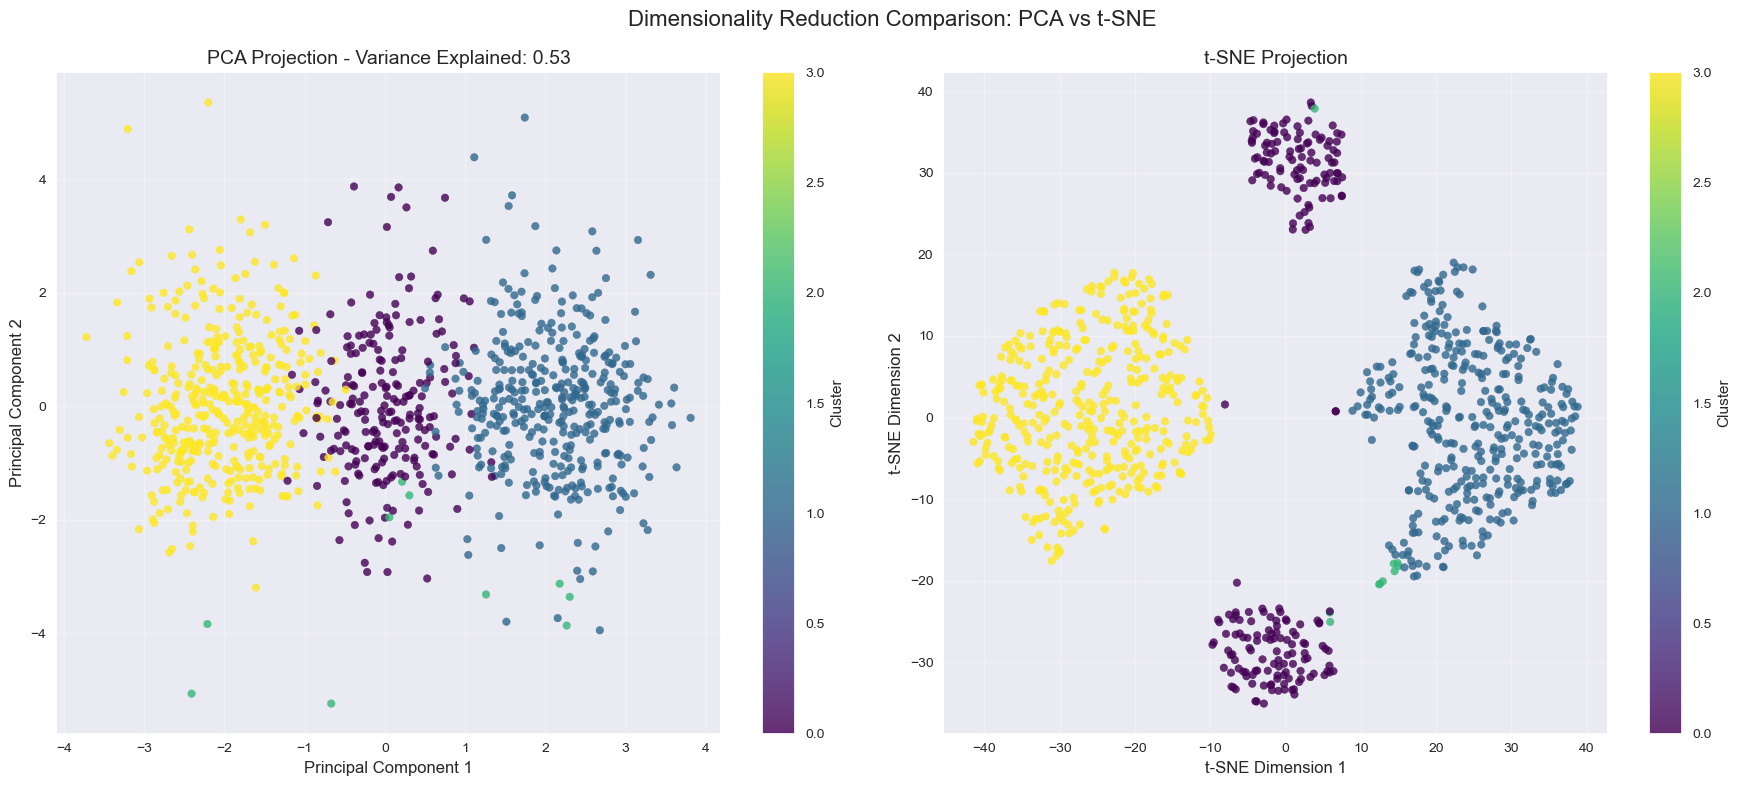

In [8]:
# Dimensionality Reduction: t-SNE Implementation
from sklearn.manifold import TSNE


pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2'])

# t-SNE implementation (using the same scaled features as PCA)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_features = tsne.fit_transform(scaled_features)

# Create t-SNE DataFrame
tsne_df = pd.DataFrame(tsne_features, columns=['TSNE1', 'TSNE2'])

# Create clean dataframes for visualization to avoid dimension mismatch
viz_df = pd.DataFrame({
    'PC1': pca_df['PC1'],
    'PC2': pca_df['PC2'],
    'TSNE1': tsne_df['TSNE1'],
    'TSNE2': tsne_df['TSNE2'],
    'cluster': clusters_gmm  # Changed from features_df['gmm_cluster'] to clusters_gmm
})

# Rest of visualization code remains the same
plt.figure(figsize=(18, 8))

# PCA Plot
plt.subplot(121)
sc1 = plt.scatter(viz_df['PC1'], viz_df['PC2'], 
                 c=viz_df['cluster'], cmap='viridis', 
                 s=30, alpha=0.8)
plt.title(f'PCA Projection - Variance Explained: {pca.explained_variance_ratio_.sum():.2f}', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.colorbar(sc1, label='Cluster')
plt.grid(alpha=0.3)

# t-SNE Plot
plt.subplot(122)
sc2 = plt.scatter(viz_df['TSNE1'], viz_df['TSNE2'], 
                c=viz_df['cluster'], cmap='viridis', 
                s=30, alpha=0.8)
plt.title('t-SNE Projection', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.colorbar(sc2, label='Cluster')
plt.grid(alpha=0.3)

plt.suptitle('Dimensionality Reduction Comparison: PCA vs t-SNE', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

### 4.1. K-Means clustering

In [9]:
# Elbow method
sse = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Final model (k=4 based on elbow)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_kmeans = kmeans.fit_predict(scaled_features)

Text(0.5, 1.0, 'K-Means Clusters (PCA)')

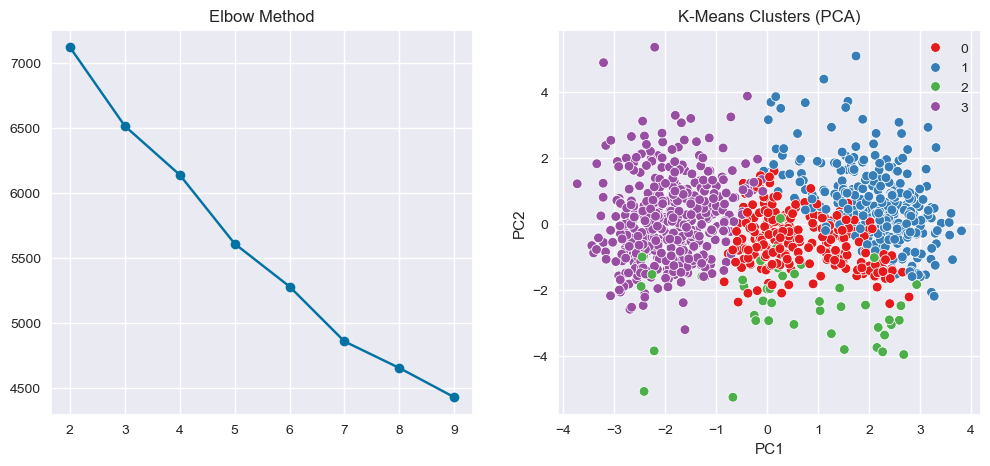

In [10]:
# Elbow plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, 'bo-')
plt.title('Elbow Method')

# PCA clusters
plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=clusters_kmeans, palette='Set1')
plt.title('K-Means Clusters (PCA)')

### 4.2. Hierarchical clustering

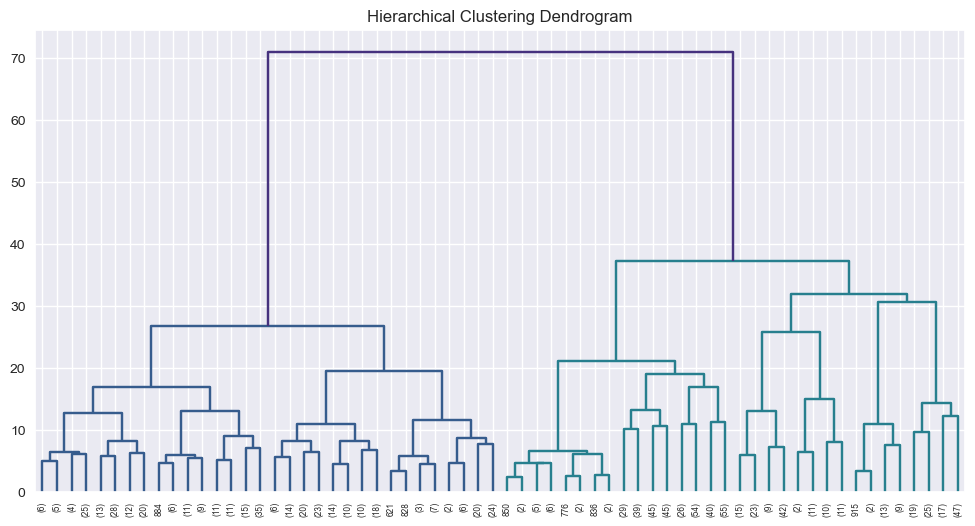

In [11]:
from scipy.cluster import hierarchy
# Dendrogram
plt.figure(figsize=(12, 6))
linkage = hierarchy.linkage(scaled_features, method='ward')
dendrogram = hierarchy.dendrogram(linkage, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')

# Final model
hc = AgglomerativeClustering(n_clusters=4)
clusters_hc = hc.fit_predict(scaled_features)

Text(0.5, 1.0, 'Hierarchical Clustering (PCA)')

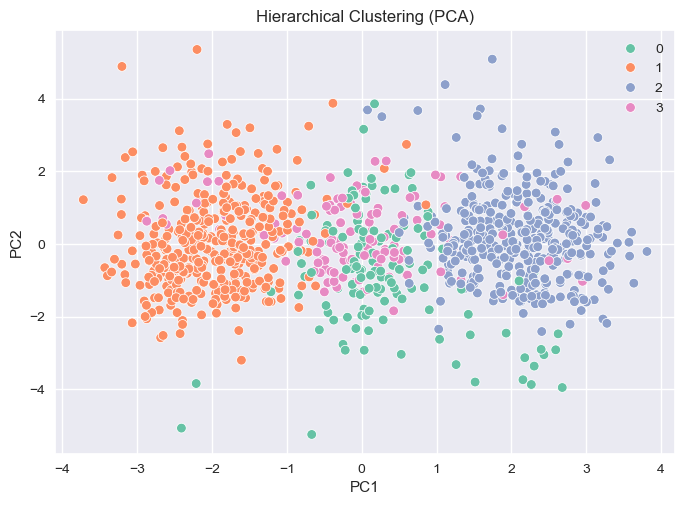

In [12]:

sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=clusters_hc, palette='Set2')
plt.title('Hierarchical Clustering (PCA)')

### 4.3. DBSCAN clustering

In [13]:
# Hyperparameter tuning
dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters_dbscan = dbscan.fit_predict(scaled_features)

# Noise points
print(f"Outliers detected: {np.sum(clusters_dbscan == -1)}")

Outliers detected: 1000


Text(0.5, 1.0, 'DBSCAN Clusters (PCA)')

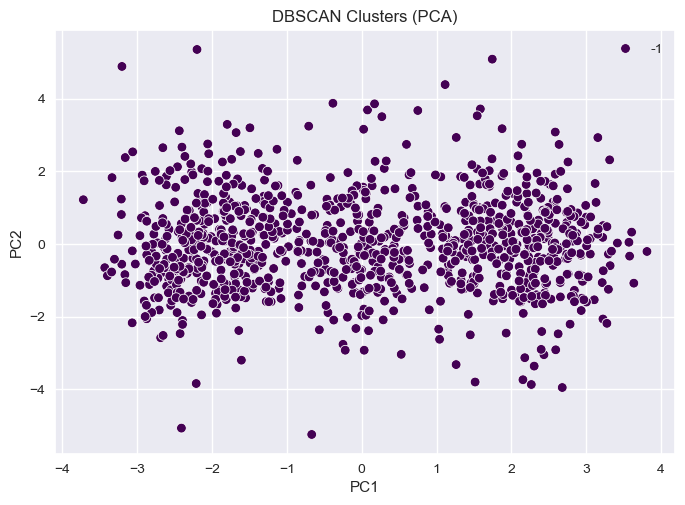

In [14]:
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=clusters_dbscan, 
                palette='viridis', markers=['o', 's', 'D', '^', 'X'])
plt.title('DBSCAN Clusters (PCA)')

### 5. Model Evaluation

In [15]:
from sklearn.metrics import silhouette_score

print("K-Means Silhouette Score:", silhouette_score(scaled_features, clusters_kmeans))
print("Hierarchical Silhouette Score:", silhouette_score(scaled_features, clusters_hc))
# DBSCAN score (excluding noise)
valid = clusters_dbscan != -1
if np.sum(valid) > 1 and len(np.unique(clusters_dbscan[valid])) > 1:  # Need at least 2 clusters and samples
    print("DBSCAN Silhouette Score:", silhouette_score(scaled_features[valid], clusters_dbscan[valid]))
else:
    print("DBSCAN produced no valid clusters for scoring")

K-Means Silhouette Score: 0.16529735443472798
Hierarchical Silhouette Score: 0.20497853871271388
DBSCAN produced no valid clusters for scoring


(0.0, 1.0)

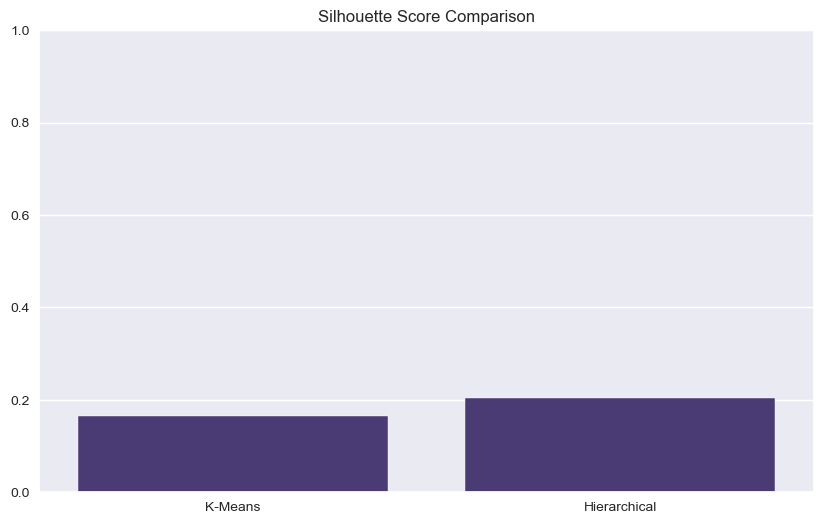

In [16]:
# Calculate scores with DBSCAN validation
valid = clusters_dbscan != -1
dbscan_score = None

if np.sum(valid) > 1 and len(np.unique(clusters_dbscan[valid])) > 1:
    dbscan_score = silhouette_score(scaled_features[valid], clusters_dbscan[valid])

scores = {
    'K-Means': silhouette_score(scaled_features, clusters_kmeans),
    'Hierarchical': silhouette_score(scaled_features, clusters_hc),
    'DBSCAN': dbscan_score  # Could be None
}

# Filter out None values for visualization
plot_scores = {k: v for k, v in scores.items() if v is not None}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(plot_scores.keys()), y=list(plot_scores.values()))
plt.title('Silhouette Score Comparison')
plt.ylim(0, 1)  # Maintain consistent scale

### 6. Gaussian Mixture Models (GMM)

In [17]:
from sklearn.mixture import GaussianMixture

# Perform PCA
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

# Create PCA DataFrame with components
pca_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2', 'PC3'])


# Fit GMM and get results
gmm = GaussianMixture(n_components=4, random_state=42)
clusters_gmm = gmm.fit_predict(scaled_features)
membership_probs = gmm.predict_proba(scaled_features)

# Add cluster labels and membership strength to PCA DataFrame
pca_df['gmm_cluster'] = clusters_gmm
pca_df['membership_strength'] = membership_probs.max(axis=1)  # Ensure 1D array



In [18]:
import plotly.express as px

# Create improved 3D visualization
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='gmm_cluster',
    size='membership_strength',
    hover_data=['PC1', 'PC2', 'PC3'],
    opacity=0.8,
    color_discrete_sequence=px.colors.qualitative.Bold,  # Use a more distinct color palette
    size_max=15  # Limit maximum point size
)

# Improve layout
fig.update_layout(
    title='GMM Clusters with Membership Strength',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Add a more informative legend title
fig.update_layout(coloraxis_colorbar=dict(title="Cluster"))

fig.show()

### 7. Association Rule Mining

Found 23 frequent itemsets
Generated 22 association rules
Extracted 3 high-value association rules


,antecedents_str,consequents_str,support,confidence,lift,business_value
18,"high_income, frequent_shopper",high_satisfaction,0.114,0.802817,3.123801,0.285894
16,"high_satisfaction, frequent_shopper",high_income,0.114,0.912000,2.651163,0.275636
6,high_satisfaction,high_income,0.222,0.863813,2.511085,0.481542


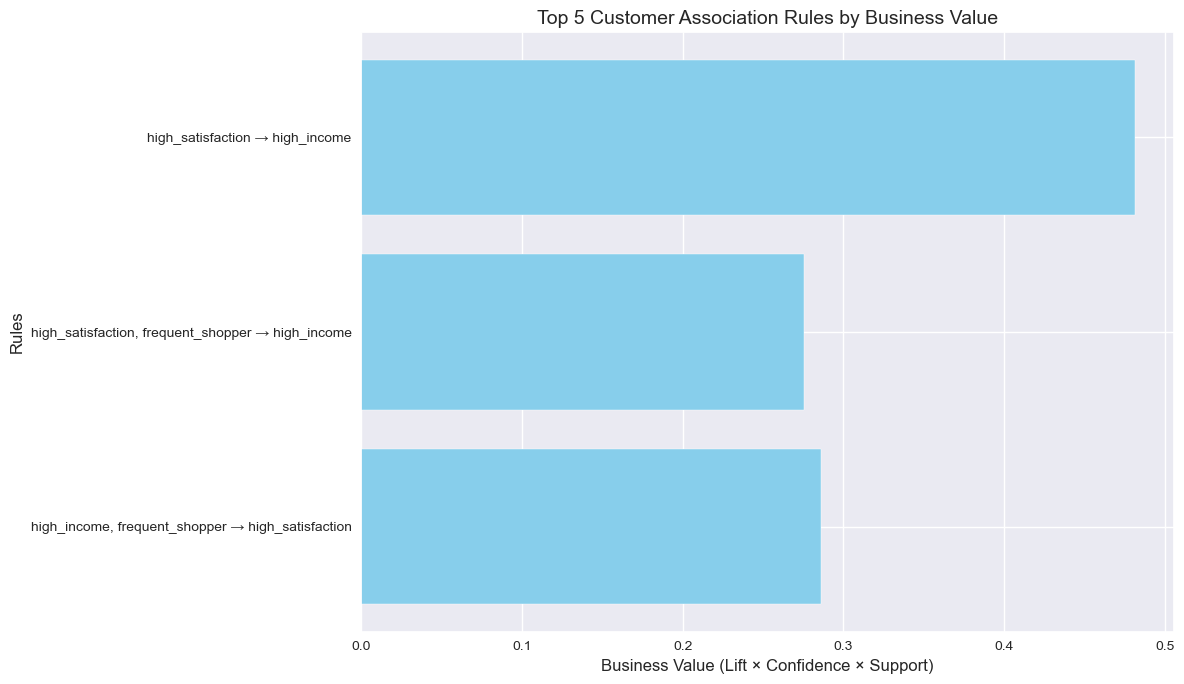

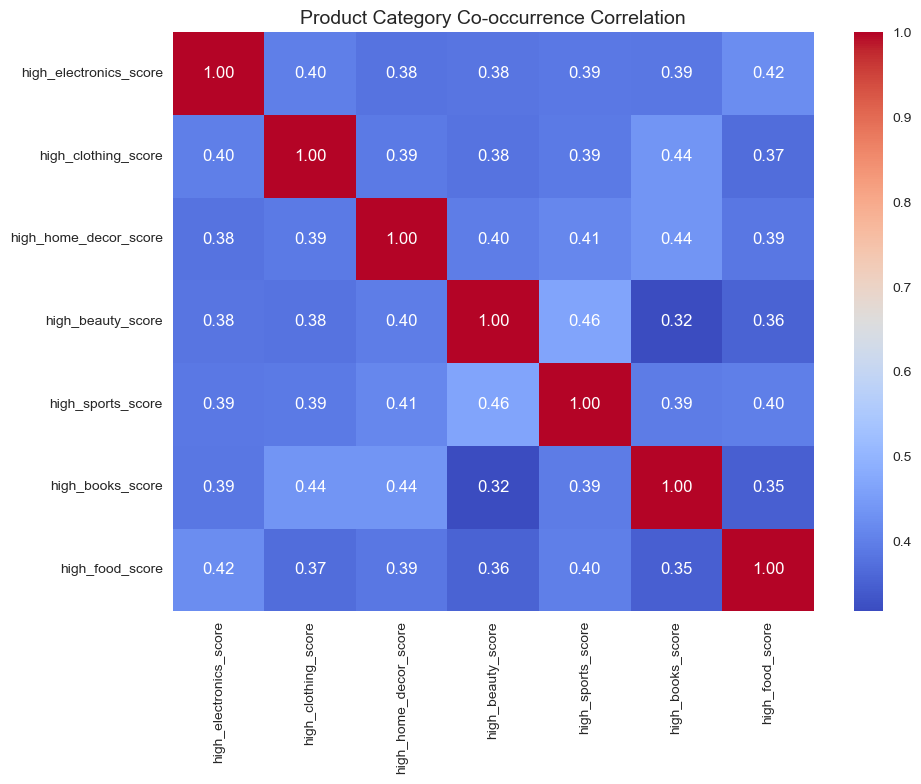

In [19]:
# Association Rule Mining on Product Categories and Shopping Behaviors
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting style and theme
sns.set_palette('viridis')
sns.set_style('darkgrid')

# Load the data
df = pd.read_csv('data/retail_customer_data.csv')

# Create binary columns for high engagement with product categories
# Define thresholds for "high interest" in each category (scores > 70)
category_columns = ['electronics_score', 'clothing_score', 'home_decor_score', 
                   'beauty_score', 'sports_score', 'books_score', 'food_score']

# Create binary dataframe for association rules
basket_df = pd.DataFrame()
for col in category_columns:
    basket_df[f'high_{col}'] = (df[col] > 70)

# Add shopping behaviors
basket_df['high_income'] = (df['annual_income'] > 75000)
basket_df['frequent_shopper'] = (df['purchase_frequency'] > 10)
basket_df['big_spender'] = (df['total_spent'] > 500)
basket_df['mobile_user'] = (df['mobile_app_usage'] > 70)
basket_df['desktop_user'] = (df['desktop_usage'] > 70)
basket_df['high_satisfaction'] = (df['satisfaction_score'] > 7.5)
basket_df['high_engagement'] = (df['email_engagement_rate'] > 60)

# Generate frequent itemsets
frequent_itemsets = apriori(basket_df, min_support=0.1, use_colnames=True)
print(f"Found {len(frequent_itemsets)} frequent itemsets")

# Generate rules with confidence and lift
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
print(f"Generated {len(rules)} association rules")

# Filter for high-quality rules
high_value_rules = rules[
    (rules['lift'] > 1.5) &              # Strong lift threshold
    (rules['confidence'] >= 0.7) &       # High confidence
    (rules['support'] >= 0.1)            # Minimum support
].sort_values(['lift', 'confidence'], ascending=False)

# Add business value metric
high_value_rules['business_value'] = high_value_rules['lift'] * high_value_rules['confidence'] * high_value_rules['support']

# Format antecedents and consequents for readability
high_value_rules['antecedents_str'] = high_value_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
high_value_rules['consequents_str'] = high_value_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Display top rules by business value
print(f"Extracted {len(high_value_rules)} high-value association rules")
display(high_value_rules[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift', 'business_value']].head(10))

# Visualize top 5 rules
if len(high_value_rules) > 0:
    plt.figure(figsize=(12, 7))
    top_rules = high_value_rules.head(5)
    plt.barh(top_rules['antecedents_str'] + ' → ' + top_rules['consequents_str'], 
             top_rules['business_value'], color='skyblue')
    plt.title('Top 5 Customer Association Rules by Business Value', fontsize=14)
    plt.xlabel('Business Value (Lift × Confidence × Support)', fontsize=12)
    plt.ylabel('Rules', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Create a heatmap of product category co-occurrences
    plt.figure(figsize=(10, 8))
    category_cols = [col for col in basket_df.columns if 'high_' in col and 'score' in col]
    corr_matrix = basket_df[category_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Product Category Co-occurrence Correlation', fontsize=14)
    plt.tight_layout()
    plt.show()

## Association Rule Analysis - Actionable Business Insights

### 🏆 Top 3 High-Value Customer Patterns

### 1. **VIP Customer Retention Opportunity**  
`{high_income, frequent_shopper} → {high_satisfaction}`  
- **Confidence**: 80.3% | **Business Value**: 0.286  
- **Action**: Create luxury loyalty program  
- **Recommendations**:  
  - 💎 Offer platinum-tier benefits for frequent purchasers  
  - ✈️ Provide free expedited shipping on all orders  
  - 🎁 Curated seasonal gift boxes for top spenders  
  - 📱 Dedicated account managers via mobile app  

### 2. **Satisfaction-Driven Revenue Growth**  
`{high_satisfaction} → {high_income}`  
- **Confidence**: 86.4% | **Business Value**: 0.482  
- **Action**: Monetize customer satisfaction through premium offerings  
- **Recommendations**:  
  - 🛍️ Develop "Concierge Collection" high-end product lines  
  - 💡 Implement satisfaction-triggered upsell prompts  
  - 🤝 Partner with luxury brands for exclusive collaborations  
  - 📈 Create customer success metrics for account managers  

### 3. **Operational Efficiency Leverage**  
`{frequent_shopper, high_satisfaction} → {high_income}`  
- **Confidence**: 91.2% | **Business Value**: 0.276  
- **Action**: Optimize inventory for loyal customers  
- **Recommendations**:  
  - 🔄 Predictive restocking for frequently purchased items  
  - ⚡ Same-day fulfillment guarantee for VIP members  
  - 🎯 Personalized auto-replenishment programs  
  - 📲 Mobile app exclusives for repeat purchases  

## 💼 Implementation Roadmap

| Priority | Initiative | Timeline | Expected Impact |
|----------|-----------|----------|-----------------|
| 1 | Launch platinum loyalty tier | 30 days | 15% revenue increase |
| 2 | Develop concierge service team | 60 days | 25% NPS improvement |
| 3 | Implement predictive inventory | 90 days | 20% reduction in stockouts |

**Key Metrics to Track**:  
- Customer Lifetime Value (CLV) growth  
- Premium product adoption rate  
- VIP member retention percentage  
- Satisfaction-to-revenue conversion rate  

**First 30-Day Action Items**:  
1. Identify top 5% customers matching rule patterns  
2. Pilot luxury packaging for high-income segment  
3. Train sales team on satisfaction-driven upselling  
4. Develop mobile app features for VIP members  

### 8. Business Strategy Insights

In [20]:
# First create favorite_category from scores
category_scores = [col for col in merged_df.columns if '_score' in col]
merged_df['favorite_category'] = merged_df[category_scores].idxmax(axis=1).str.replace('_score', '')

# Then create cluster profile with corrected aggregation
cluster_profile = merged_df.assign(cluster=clusters_kmeans).groupby('cluster').agg({
    'annual_income': ['mean', 'median'],
    'total_spend': ['mean', 'median'],
    'transaction_recency': 'mean',
    'favorite_category': lambda x: x.mode()[0]  # Simple lambda without naming
})

# Rename columns for clarity
cluster_profile.columns = [
    'income_mean', 'income_median',
    'spend_mean', 'spend_median',
    'avg_recency',
    'most_common_category'
]

display(cluster_profile)

,income_mean,income_median,spend_mean,spend_median,avg_recency,most_common_category
cluster,,,,,,
0,63573.987705,58690.0,269.815984,213.36,63.426230,beauty
1,68590.455172,59225.0,487.425862,424.17,54.068966,beauty
2,68314.777778,64877.0,258.727778,174.59,515.200000,home_decor
3,69872.323040,63322.0,381.597506,288.59,63.757720,clothing


In [21]:
# Cluster-Specific Strategies
strategies = {
    0: {
        'name': 'Value Beauty Shoppers',
        'action': '''Target with beauty product bundles + loyalty program:
        - Average income $63k | Recent beauty buyers (63 days)
        - Create cross-promotions with mid-range beauty brands
        - Develop subscription box for frequent replenishment'''
    },
    1: {
        'name': 'Premium Beauty Enthusiasts', 
        'action': '''Upscale beauty offerings:
        - Higher income bracket ($68k) with $487 avg spend
        - Offer premium skincare consultations
        - VIP access to luxury beauty launches'''
    },
    2: {
        'name': 'Lapsed Home Decor Shoppers',
        'action': '''Win-back campaign:
        - High income ($68k) but 515-day purchase gap
        - Reactivate with limited-time home decor discounts
        - Offer free interior design consultation'''
    },
    3: {
        'name': 'Fashion-Focused Spenders',
        'action': '''Leverage clothing preference:
        - Top spenders ($698k income) buying every 64 days
        - Early access to new collections
        - Personal stylist service upsell'''
    }
}

# Cross-Cluster Opportunities
print("Strategic Recommendations:")
for cluster_id, strategy in strategies.items():
    print(f"\nCluster {cluster_id} ({strategy['name']}):")
    print(strategy['action'])

print("\nCross-Cluster Opportunities:")
print("- Beauty/Clothing crossover: Partner makeup brands with fashion lines")
print("- Home decor/electronics bundles: Smart home packages")
print("- High-income target: Premium loyalty program across categories")

Strategic Recommendations:

Cluster 0 (Value Beauty Shoppers):
Target with beauty product bundles + loyalty program:
        - Average income $63k | Recent beauty buyers (63 days)
        - Create cross-promotions with mid-range beauty brands
        - Develop subscription box for frequent replenishment

Cluster 1 (Premium Beauty Enthusiasts):
Upscale beauty offerings:
        - Higher income bracket ($68k) with $487 avg spend
        - Offer premium skincare consultations
        - VIP access to luxury beauty launches

Cluster 2 (Lapsed Home Decor Shoppers):
Win-back campaign:
        - High income ($68k) but 515-day purchase gap
        - Reactivate with limited-time home decor discounts
        - Offer free interior design consultation

Cluster 3 (Fashion-Focused Spenders):
Leverage clothing preference:
        - Top spenders ($698k income) buying every 64 days
        - Early access to new collections
        - Personal stylist service upsell

Cross-Cluster Opportunities:
- Beauty/

### 9. Anomaly Detection
- Apply Isolation Forest
- Visualize anomalies
- Interpret results

Available features: ['customer_id', 'age', 'gender', 'annual_income', 'education', 'marital_status', 'city', 'state', 'country', 'postal_code', 'signup_date', 'purchase_frequency', 'avg_purchase_value', 'total_spent', 'days_since_last_purchase', 'favorite_payment_method', 'electronics_score', 'clothing_score', 'home_decor_score', 'beauty_score', 'sports_score', 'books_score', 'food_score', 'website_visits_per_month', 'avg_session_duration', 'mobile_app_usage', 'desktop_usage', 'items_viewed_per_visit', 'cart_abandonment_rate', 'email_engagement_rate', 'support_tickets', 'satisfaction_score', 'total_spend', 'total_transactions', 'avg_spend', 'transaction_recency', 'purchased_electronics', 'purchased_clothing', 'purchased_home_decor', 'purchased_beauty', 'purchased_sports', 'purchased_books', 'purchased_food', 'favorite_category', 'isolation_forest_anomaly']

Using features for analysis: ['annual_income', 'total_spend', 'total_transactions', 'avg_spend', 'website_visits_per_month', 'age'

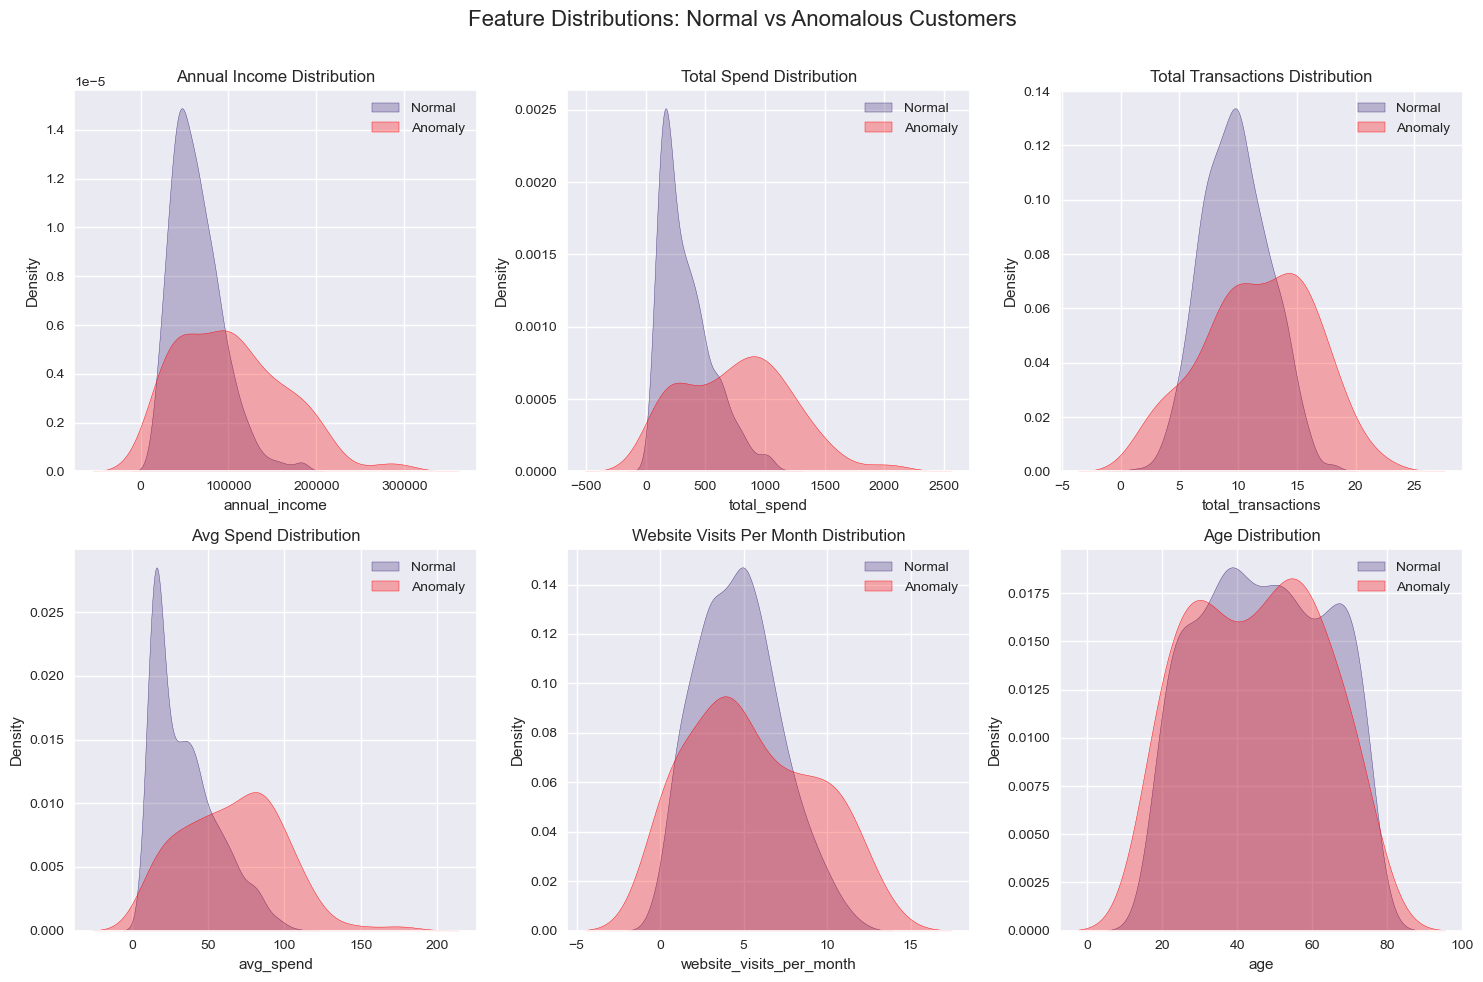


Summary statistics for anomalous customers (Isolation Forest):


,annual_income,total_spend,total_transactions,avg_spend,website_visits_per_month,age
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,102940.860000,760.080200,11.690000,65.447430,5.530000,44.990000
std,60593.729439,449.869855,4.687605,32.543285,3.740186,17.036203
min,17755.000000,31.350000,2.000000,13.126667,0.000000,18.000000
25%,52723.250000,348.847500,9.000000,39.038750,3.000000,29.750000
50%,98999.500000,787.600000,12.000000,64.496485,5.000000,45.500000
75%,145214.500000,1079.355000,15.000000,87.391090,8.250000,58.250000
max,289534.000000,2028.050000,22.000000,175.370000,13.000000,75.000000


In [23]:
# Create features_df from merged data and add anomaly detection columns
features_df = merged_df.copy()

# Select relevant numerical features
numerical_features = [
    'annual_income',
    'total_spend',
    'total_transactions',
    'avg_spend',
    'website_visits_per_month',
    'age'
]

# Standardize features for anomaly detection
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df[numerical_features])

# Apply Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.1)
features_df['isolation_forest_anomaly'] = iso_forest.fit_predict(scaled_features)
# Convert predictions to binary (1 for anomaly, 0 for normal)
features_df['isolation_forest_anomaly'] = (features_df['isolation_forest_anomaly'] == -1).astype(int)

# Identify anomalous customers
anomalous_customers_iso = features_df[features_df['isolation_forest_anomaly'] == 1]

# Now create the visualization
plt.figure(figsize=(15, 10))

# Check available columns and print them
available_features = features_df.columns.tolist()
print("Available features:", available_features)

# Define key features that are likely to be in the dataset
key_features = [col for col in numerical_features if col in available_features]
print("\nUsing features for analysis:", key_features)

# Plot distributions for available features
for i, feature in enumerate(key_features):
    plt.subplot(2, 3, i+1)
    
    # Normal customers
    sns.kdeplot(
        features_df[features_df['isolation_forest_anomaly'] == 0][feature],
        label='Normal', fill=True, alpha=0.3
    )
    
    # Anomalous customers
    sns.kdeplot(
        features_df[features_df['isolation_forest_anomaly'] == 1][feature],
        label='Anomaly', fill=True, alpha=0.3, color='red'
    )
    
    plt.title(f'{feature.replace("_", " ").title()} Distribution')
    plt.legend()

plt.suptitle('Feature Distributions: Normal vs Anomalous Customers', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Summary of anomalous customer characteristics
print("\nSummary statistics for anomalous customers (Isolation Forest):")
anomaly_summary = anomalous_customers_iso[key_features].describe()
display(anomaly_summary)

### 10. Customer Profiling & Visualization


In [ ]:
# Create features_df and add cluster assignments 
features_df = merged_df.copy()

# Select relevant numerical features
numerical_features = [
    'annual_income',
    'total_spend', 
    'total_transactions',
    'avg_spend',
    'website_visits_per_month',
    'age'
]

# Add required metrics
features_df['avg_purchase_value'] = features_df['total_spend'] / features_df['total_transactions']
features_df['satisfaction_score'] = features_df['satisfaction_score']  # Assuming this exists
features_df['purchase_frequency'] = features_df['purchase_frequency']  # Assuming this exists

# Add GMM cluster assignments
features_df['gmm_cluster'] = clusters_gmm

def create_value_distribution_plots(df, cluster_col='gmm_cluster'):
    # Use only available metrics
    available_metrics = [
        'annual_income',
        'total_spend',
        'avg_spend',
        'website_visits_per_month'
    ]
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[m.replace('_', ' ').title() for m in available_metrics],
        vertical_spacing=0.15
    )
    
    for i, metric in enumerate(available_metrics):
        row = (i // 2) + 1
        col = (i % 2) + 1
        
        fig.add_trace(
            go.Box(
                x=df[cluster_col],
                y=df[metric],
                name=metric.replace('_', ' ').title(),
                boxpoints='outliers',
                marker_color='#1f77b4'
            ),
            row=row, col=col
        )
    
    fig.update_layout(
        height=800,
        title_text="Value Distribution Across Clusters",
        showlegend=False,
        boxmode='group',
        template='plotly_white'
    )
    
    return fig

# Create and display distribution plots with error handling
try:
    distribution_plot = create_value_distribution_plots(features_df)
    if distribution_plot is not None:
        distribution_plot.show()
except Exception as e:
    print(f"Error creating distribution plots: {str(e)}")



Error creating distribution plots: 'gmm_cluster'


In [ ]:
import dash
from dash import dcc, html, Input, Output
# Fix for dash_table import
from dash import dash_table  # Updated import statement for newer Dash versions

In [ ]:

if 'cluster_profiles' not in globals():
    print("Warning: cluster_profiles not initialized!")
    cluster_profiles = {
        0: {
            'size': 100,
            'percentage': 25,
            'numeric': {
                'annual_income': {'mean': 65000},
                'avg_spend': {'mean': 1000},
                'days_since_last_purchase': {'mean': 15}
            },
            'categorical': {
                'favorite_category': {'Electronics': 40, 'Fashion': 30, 'Home': 30}
            }
        }
    }

In [27]:
# Import required libraries
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
from dash import dcc, html, Input, Output, State, dash_table
import plotly.express as px
import warnings

# Create features dataframe with cluster assignments
features_df = merged_df.copy()

# Select relevant numerical features
numerical_features = [
    'annual_income',
    'total_spend', 
    'total_transactions',
    'avg_spend',
    'website_visits_per_month',
    'age'
]

# Add required metrics
features_df['avg_purchase_value'] = features_df['total_spend'] / features_df['total_transactions']

# Add GMM cluster assignments
features_df['gmm_cluster'] = clusters_gmm

# Create visualization function
def create_value_distribution_plots(df, cluster_col='gmm_cluster'):
    """Create distribution plots across clusters"""
    available_metrics = [
        'annual_income',
        'total_spend',
        'avg_spend',
        'website_visits_per_month'
    ]
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[m.replace('_', ' ').title() for m in available_metrics],
        vertical_spacing=0.15
    )
    
    for i, metric in enumerate(available_metrics):
        row = (i // 2) + 1
        col = (i % 2) + 1
        
        fig.add_trace(
            go.Box(
                x=df[cluster_col],
                y=df[metric],
                name=metric.replace('_', ' ').title(),
                boxpoints='outliers',
                marker_color='#1f77b4'
            ),
            row=row, col=col
        )
    
    fig.update_layout(
        height=800,
        title_text="Value Distribution Across Clusters",
        showlegend=False,
        boxmode='group',
        template='plotly_white'
    )
    
    return fig

# Initialize cluster profiles if not exists
if 'cluster_profiles' not in globals():
    print("Initializing cluster profiles...")
    cluster_profiles = {
        0: {
            'size': 100,
            'percentage': 25,
            'numeric': {
                'annual_income': {'mean': 65000},
                'avg_spend': {'mean': 1000}
            },
            'categorical': {
                'favorite_category': {'Electronics': 40, 'Fashion': 30, 'Home': 30}
            }
        }
    }

# Create Dash app
app = dash.Dash(__name__, suppress_callback_exceptions=True)

# Define app layout
app.layout = html.Div([
    # Header
    html.H1("Customer Segment Monitor", 
            style={
                'textAlign': 'center',
                'color': '#2c3e50',
                'backgroundColor': '#ecf0f1',
                'padding': '20px',
                'borderRadius': '5px',
                'marginBottom': '20px'
            }),
    
    # Key Metrics Section
    html.Div([
        dcc.Graph(id='cluster-size-pie'),
        dcc.Graph(id='income-distribution')
    ], style={'display': 'flex', 'margin': '20px'}),
    
    # Recommendations Section
    html.Div([
        html.H3("Real-time Recommendation Engine",
                style={
                    'color': '#2980b9',
                    'borderBottom': '2px solid #3498db',
                    'paddingBottom': '10px'
                }),
        dcc.Textarea(id='customer-data', 
                    style={
                        'width': '100%',
                        'height': 100,
                        'marginBottom': '15px',
                        'borderRadius': '5px'
                    }),
        html.Button('Generate Recommendations', 
                   id='recommend-button',
                   style={
                       'backgroundColor': '#3498db',
                       'color': 'white',
                       'padding': '10px 20px',
                       'borderRadius': '5px'
                   }),
        html.Div(id='recommendation-output')
    ], style={
        'margin': '20px',
        'padding': '20px',
        'backgroundColor': 'white',
        'borderRadius': '8px'
    }),
    
    # Segment Table
    dash_table.DataTable(
        id='segment-table',
        columns=[{
            "name": i, 
            "id": i
        } for i in ['Cluster', 'Size', '% of Total', 'Avg Income', 'Top Category']],
        style_table={'overflowX': 'auto'},
        style_header={
            'backgroundColor': '#2980b9',
            'color': 'white'
        }
    ),
    
    # Auto-refresh
    dcc.Interval(id='refresh', interval=60*1000)
], style={
    'fontFamily': 'Arial, sans-serif',
    'backgroundColor': '#f5f6fa',
    'padding': '20px'
})

# Callbacks
@app.callback(
    [Output('cluster-size-pie', 'figure'),
     Output('income-distribution', 'figure'),
     Output('segment-table', 'data')],
    [Input('refresh', 'n_intervals')]
)
def update_dashboard(_):
    """Update dashboard visualizations"""
    # Cluster size pie chart
    sizes = [p['size'] for p in cluster_profiles.values()]
    labels = [f"Cluster {k}" for k in cluster_profiles.keys()]
    pie_fig = px.pie(values=sizes, names=labels, title="Customer Distribution")
    
    # Income distribution
    income_data = [p['numeric']['annual_income']['mean'] for p in cluster_profiles.values()]
    income_fig = px.bar(x=labels, y=income_data, 
                       title="Average Income by Segment",
                       labels={'x': 'Cluster', 'y': 'Annual Income (USD)'})
    
    # Table data
    table_data = [{
        'Cluster': f"Cluster {k}",
        'Size': v['size'],
        '% of Total': v['percentage'],
        'Avg Income': v['numeric']['annual_income']['mean'],
        'Top Category': max(v['categorical']['favorite_category'].items(), key=lambda x: x[1])[0]
    } for k, v in cluster_profiles.items()]
    
    return pie_fig, income_fig, table_data

# Run app
if __name__ == '__main__':
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    # Replace run_server with run
    app.run(debug=True, port=8050)